In [ ]:
"""
Developing a logistic regression model and looking at topic clustering using LDA with Kaggle Dataset
"""

In [2]:
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
# Reads in Kaggle dataset to dataframes
df = pd.read_csv('archive/Fake.csv')
df2 = pd.read_csv('archive/True.csv')

In [3]:
df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
# Creates a new column 'true' for the two dataframes and sets 'true' to 0 for fake news and 
# 1 for real news
df['true'] = 0
df2['true'] = 1

In [5]:
# Combine the two dataframs into one dataframe
df_all = pd.concat([df, df2])
df_all.head()

,title,text,subject,date,true
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [6]:
# Size of the data set
df_all.shape

(44898, 5)

In [7]:
# Cleans up the text by removing quotes, alphanumeric words, punctuation, and setting everything to lowercase
import re
import string

apostrophe = lambda x: re.sub("\'", '', x)
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df_all['text'] = df_all['text'].map(apostrophe).map(alphanumeric).map(punc_lower)
df_all.head()

,title,text,subject,date,true
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump just couldn t wish all americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,on friday it was revealed that former milwauk...,News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,on christmas day donald trump announced that ...,News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used his annual christmas day mes...,News,"December 25, 2017",0


In [9]:
# Split the data into X and y data sets
X = df_all['text']
y = df_all['true']

In [10]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Generates two tf-idf vectorizers, one with unigrams and one with bigrams
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

In [12]:
# Create a logistic regression model 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [13]:
# This method takes actual values and predicted values and produces a confusion matrix
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

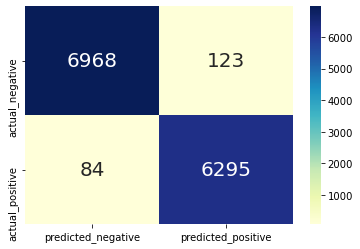

In [14]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

In [15]:
# Classification report for the logistic regression model
print(classification_report(y_test, y_pred_tfidf1_lr))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7091
           1       0.98      0.99      0.98      6379

    accuracy                           0.98     13470
   macro avg       0.98      0.98      0.98     13470
weighted avg       0.98      0.98      0.98     13470



In [51]:
# Creates a count vectorizer to generate term-document matrices of counts
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

In [42]:
# Generates a tf-idf vectorizer from the CountVectorizer
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english')
dtm_tf = tf_vectorizer.fit_transform(df['text'])
print(dtm_tf.shape)

/Users/Julia/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(23481, 79828)


In [45]:
# Use the tf-idf vectorizer from the CountVectorizer
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(dtm_tf)

# Used the tf-idf with one unigram.  Worked less well, so used the one above
#lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
#lda_tfidf.fit(tfidf1)

/Users/Julia/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(random_state=0)

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [46]:
# Generates visualizations for the LDA
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/Julia/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.025935  0.174474       1        1  19.429511
4      0.022920  0.044070       2        1  14.641444
0     -0.071157  0.119054       3        1  13.615209
8     -0.074890 -0.013394       4        1  12.772480
9     -0.029997 -0.097027       5        1  12.005377
1     -0.104873  0.036216       6        1  11.580492
3     -0.030282 -0.113355       7        1   5.552106
6     -0.017624 -0.038725       8        1   3.898924
7     -0.006212 -0.104524       9        1   3.412651
2      0.286181 -0.006790      10        1   3.091805, topic_info=          Term          Freq         Total Category  logprob  loglift
72500    trump  78569.000000  78569.000000  Default  30.0000  30.0000
12573  clinton  18875.000000  18875.000000  Default  29.0000  29.0000
31264  hillary  13894.000000  13894.000000  Default  28.0000  28.0000
73108  twitter  11582.000000  11582.000000  Default  27.0000  27.0000
13245      com   8399.000000   8399.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
66139   speech    478.329873   3977.901510  Topic10  -5.8002   1.3582
77039     week    473.836052   4863.558619  Topic10  -5.8097   1.1478
53757   police    503.801788   8965.403936  Topic10  -5.7483   0.5975
40486     like    509.074817  17888.192194  Topic10  -5.7379  -0.0829
47722      new    499.154195  14163.665403  Topic10  -5.7576   0.1309

[891 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
180        7  0.062099        abid
180        9  0.931482        abid
236        2  0.834530    abortion
236        3  0.004176    abortion
236        4  0.002784    abortion
...      ...       ...         ...
79778      4  0.013912  zuckerberg
79778      6  0.041737  zuckerberg
79778      7  0.027825  zuckerberg
79778      9  0.890394  zuckerberg
79778     10  0.013912  zuckerberg

[3515 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 9, 10, 2, 4, 7, 8, 3])

In [16]:
# Reads in a pickle file of data scraped from news sites
file_path = 'adfonte_media.pickle'
df_adfonte = pd.read_pickle(file_path)

In [18]:
# Generates a tf-idf vectorizer from the above data
adfonte_tdidf = tfidf1.transform(df_adfonte['text'])

In [20]:
# Uses the above model to make predictions using this scraped data set.
predictions = lr.predict(adfonte_tdidf)

In [31]:
# Look at predictions vs actual values 
list(zip(predictions, df_adfonte['true']))[:5]

[(0, 1), (1, 1), (0, 1), (0, 1), (1, 1)]

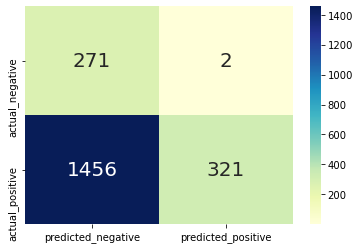

In [25]:
# Generates confusion matrix image for this scraped data
cm5 = conf_matrix(df_adfonte['true'], predictions)

In [ ]:
"""
Based on this analysis, it seems the model generated using the data set from Kaggle
is not very good at predicting real life scraped data.  I looked into comments in 
Kaggle for this data set, and it seems other people have found anomalies in this 
data set as well and it is not a good representation of real data.
"""